In [404]:
# read clean data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np

df = pd.read_csv('resdf_delivery_mode_2024-02-10.csv')


df['prvs_lscs'] = df['indication'].str.contains('LSCS', case=False, na=False).astype(int)
df['prvs_abortion'] = df['indication'].str.contains('ABORTION', case=False, na=False).astype(int)
df['oligo'] = df['indication'].str.contains('OLIGO', case=False, na=False).astype(int)
df['meconium'] = df['indication'].str.contains('MECONIUM', case=False, na=False).astype(int)
df['iugr'] = df['indication'].str.contains('IUGR', case=False, na=False).astype(int)
df['gdm'] = df['indication'].str.contains('GDM', case=False, na=False).astype(int)
df['hyperthyraidisim'] = df['diagnosis'].str.contains('HYPOTHYRAIDISIM', case=False, na=False).astype(int)

def extract_info(df, column_name, start_phrase, end_phrase=None):
    if end_phrase:
        # Extracting data between start_phrase and end_phrase
        df[column_name] = df['usg'].str.extract(f'{start_phrase}(.+?){end_phrase}')
    else:
        # Extracting data after start_phrase if no end_phrase is provided
        df[column_name] = df['usg'].str.extract(f'{start_phrase}(.+)')
    # Cleaning extracted data
    df[column_name] = df[column_name].str.strip()

def extract_efw(df):
    # Extracting only the first numeric part before the space
    df['E.F.W'] = df['usg'].str.extract('E.F.W- (\d+)').astype(str)

# Extracting each piece of information
extract_info(df, 'FHR', 'FHR-', '/MIN')
extract_info(df, 'Grade', 'GRADE-', ',')
extract_info(df, 'E.F.W', 'E.F.W-', ' GMS')
extract_info(df, 'A.F.I', 'A.F.I- ', ' CM')
extract_info(df, 'Placenta', 'PLACENTA- ', ',')
extract_info(df, 'Cervix_Length', 'CERVIX-', 'CM')
df['fetus_type'] = df['usg'].str.extract(r'(\b\w+)\s+LIVE')

df['fetus_type'] = np.where(df.fetus_type.isin(['SINGL', 'SINGLWE', 'WITH']),'SINGLE', df['fetus_type'])

extract_efw(df)

df = df[~df.usg.isna()]

## To calculate the upper and lower range for imputation
def cal_lower_upper(df,min_range,max_range):
    # Generate random numbers and fill null values
    random_values = [random.uniform(min_range, max_range) if pd.isna(val) else val for val in df['kg']]

    return random_values

## Replace age and drop age with 16years

df['age'] = df['age'].replace({269.0: 26,257:25,16:21})



## Weight#############
## Replace missing weight with +/- in std deviation for weight and height
mean_weight = df['kg'].mean()
std_dev_weight=df['kg'].std()
# Define the range for random numbers
kg_upper_range=mean_weight+std_dev_weight
kg_lower_range=mean_weight-std_dev_weight
df['kg_upd']=cal_lower_upper(df,kg_lower_range,kg_upper_range)


##### Height ###########
## Replace missing weight with +/- in std deviation for weight and height
mean_height = df['height'].mean()
std_dev_height=df['height'].std()
# Define the range for random numbers
height_upper_range=mean_height+std_dev_height
height_lower_range=mean_height-std_dev_height
df['height_upd']=cal_lower_upper(df,height_lower_range,height_upper_range)

## Convert height from cms to metres
df['height_upd']=df['height_upd']/100



## Replace missing haemoglobin with mean
df['hb']=df['hb'].replace({'11..9':'11.9','10..2':'10.2','10 .1':'10.1'})
df['hb']=df['hb'].astype(float)
mean_hb = df['hb'].mean()
df['hb'].fillna(mean_hb, inplace=True)

## Replace missing ga_weeks with mean
df.ga_weeks.fillna(round(df[~df.ga_weeks.isna()].ga_weeks.astype(int).mean()))


##Looking into age and can be imputed ##TBD
#Replace for bp
df['bp']=df['bp'].replace({'10.2':'110/70'})
df['bp'].fillna('110/70', inplace=True)


## Drop rows who opted for LSCS option by default
df['maternal_request'] = df['indication'].str.contains('MATERNAL', case=False, na=False).astype(int)
df=df[df['maternal_request']==0]

df['hhh'].replace({'110/70':'NO- REACTIVE'},inplace=True)


df.fetus_type = df.fetus_type.fillna('SINGLE')


df['bmi']=((df['kg_upd'])/(df['height_upd']*df['height_upd']))

df['Placenta']=df['Placenta'].astype(str)


###Categories merged
# FUNDAL: FUNDAL FUNDAL LEFT ANTERIOR FUNDAL-POSTERIOR FUNDAL-POSTERIOR .' FUNDAL-ANTERIOR FUNDAL ANTERIOR FUNDAL . ' FUNDAL . '

# FUNDO-ANTERIOR:FUNDO-ANTERIOR FUNDO-ANTERIOR . ' FUNDO-ANTERIOR .' FUNDO-ANTERIOR . CERVIX-3.2 CM FUNDO- ANTERIOR . ' FUNDO- ANTERIOR FUNDOANT IN LOCATION .' FUNDO-ANTERIOR RIGHT LATERAL EXTENSION. NOT LOW LYING .' FUNDO-ANTERIOR NOT LOW LYING

# POSTERIOR:POSTERIOR POSTERIOR NOT LOW LYING POSTERIOR FUNDAL . A.F.I- 11.3 CM POSTERIOR RTLATERAL POSTERIOR LOW LYING POSTERIOR . ' POSTERIOR . (USG IN L.R )' POSTERIOR LEFT LATERAL POSTERIOR & FUNDAL POSTERIOR-FUNDAL . '

# ANTERIOR:ANTERIOR ANTERIOR . ANTERIOR . ' ANTERIOR . A.F.I- 10 CM ANTERIOR LEFT LATERAL ANTERIOR RIGHT FUNDAL ANTERIOR FUNDAL ANTERIOR FUNDAL . GARDE-3 . ' ANTERIOR TO THE RIGHT NOT LOW LYING . ' ANTERIOR AND LEFT LATERAL ANTERIOR LEFT LATERAL . ' ANTERIOR . '

# NAN:nan

# LEFT:LEFT LEFT LATERAL LEFT FUNDAL

# RIGHT:RIGHT RIGHT ANTERIOR RIGHT LATERAL RIGHT LATERAL POSTERIOR (SINGLE)- RIGHT LATERAL '

# OTHERS:NOT LOW LYINY POSTERIOR NATERIOR FUNDIC FUNDO-POSTERIOR FUNDO-POSTERIOR . ' FUNDO-'' FUNDO- POSTERIOR FUNDIC POSTERIOR FUNDIC PARTLY ANTERIOR FUNDIC RIGHT LATERAL FUNDIC-PARTLY ANTERIOR PARTLY' FUNDP-POSTERIOR SEPARATION LATERAL FUNDO POSTERIOR WITH LEFT LATERAL LATERLAL POSTERIOR FUN-ANTERIOR POSTEROLATERALLY


## Code to merge categories in placenta and perform one hot encoding
mapping = {
    'FUNDAL': 'FUNDAL',
    'FUNDO-ANTERIOR': 'FUNDO-ANTERIOR',
    'POSTERIOR': 'POSTERIOR',
    'ANTERIOR': 'ANTERIOR',
    'nan': 'nan',
    'LEFT': 'LEFT',
    'RIGHT': 'RIGHT'
}

# Create new columns based on mapping
for key, value in mapping.items():
    df[value] = df['Placenta'].apply(lambda x: 1 if key in x else 0)


# Define the pattern to match "AFI" followed by 10 characters
pattern = r'A.F(.{13})'

# Function to extract the matched strings
def extract_matched_strings(text):
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Extract the 10 characters after "CER"
    else:
        return None

# Apply the function to the DataFrame column
df['Extracted_String_A.F.I'] = df['usg'].apply(extract_matched_strings)
df['Extracted_String_A.F.I']=df['Extracted_String_A.F.I'].astype(str)

df['A.F.I_upd']=df['A.F.I'].fillna(df['Extracted_String_A.F.I'])

# Regular expression to extract numerical values
pattern = r'(\d+\.?\d*)'

# Function to extract numerical values
def extract_numerical_values(text):
    matches = re.findall(pattern, str(text))
    return ' '.join(matches)

# Apply the function to the DataFrame column
df['A.F.I_numerical'] = df['A.F.I_upd'].apply(extract_numerical_values)

df['A.F.I_numerical']=df['A.F.I_numerical'].replace({'176 3 6.4':'6.4','14.0 4.2':'14.0','9 10':'9','10.3 3 2.8':'10.3',
                                                     '13 14':'13',
                                                     '2306 34':'ADEQUATE',
                                                     '112':'11.2','163':'16.3'})



# Define the pattern to match "CER" followed by 10 characters
pattern = r'CERVIX-(.{5})'

# Function to extract the matched strings
def extract_matched_strings(text):
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Extract the 10 characters after "CER"
    else:
        return None

# Apply the function to the DataFrame column
df['Extracted_String_cervix'] = df['usg'].apply(extract_matched_strings)
df['Extracted_String_cervix']=df['Extracted_String_cervix'].astype(str)

df['cervix_upd']=df['Cervix_Length'].fillna(df['Extracted_String_cervix'])

# Regular expression to extract numerical values
pattern = r'(\d+\.?\d*)'

# Function to extract numerical values
def extract_numerical_values(text):
    matches = re.findall(pattern, str(text))
    return ' '.join(matches)

# # Apply the function to the DataFrame column
df['cervix_numerical'] = df['cervix_upd'].apply(extract_numerical_values)

df['cervix_numerical']=df['cervix_numerical'].replace({'2838 12':'normal','32 1719 251 12.3':'32',
                                                       '35':'3.5','41':'4.1','45':'4.5','36':'3.6','34':'3.4',
                                                       '33':'3.3','29':'2.9','32':'3.2','30':'3.0'})



## Code to update FHR


pattern = r'FHR-(\d+)'
import re
# Function to extract FHR value from a string
def extract_fhr(column_value):
    # Convert non-string values to string
    if not isinstance(column_value, str):
        column_value = str(column_value)
    fhr_match = re.search(pattern, column_value)
    if fhr_match:
        return fhr_match.group(1)
    else:
        return None

# Apply the function to the column
df['new_fhr']=df['FHR'].apply(extract_fhr)
df['fhr_upd'] = df['new_fhr'].fillna(df['FHR'])


df.drop(columns=[ 'nan','Extracted_String_A.F.I', 'A.F.I_upd','Extracted_String_cervix', 'cervix_upd','new_fhr'],inplace=True)

In [405]:
# additional transformations

def keyword_extract(df,column,keyword):
    keywords_pattern = r'\b(' + keyword + r')\b'

    df['keywords'] = df[column].str.extract(keywords_pattern, expand=False)
    return df['keywords']


for i in ['OLIGOHYDRAMNIOUS',"OLIGO","FETAL DISTRESS","DISTRESS","FETAL","BREECH",'CEPHALIC','PREVIA',
          'ECLAMPSIA' , 'PPROM', 'PROM', 'PREVIA', 'PREECLAMPSIA','OBSTRICAL']:
    key  = i
    df["col_"+str(key)]=keyword_extract(df,"diagnosis",key)
    df["col_"+str(key)]=df["col_"+str(key)].fillna(keyword_extract(df,"indication",key))
    df["col_"+str(key)]=df["col_"+str(key)].fillna(keyword_extract(df,"usg",key))
    print( df["col_"+str(key)].value_counts())


first_keywords = [entry.split()[0] if entry else None for entry in df['diagnosis']]
extracted_keywords = [keyword.split("[")[1] if "[" in keyword else None for keyword in first_keywords]
cleaned_keywords = [keyword[1:] if keyword.startswith("'") else keyword for keyword in extracted_keywords]
cleaned_keywords = [keyword[:-1] if keyword.endswith("'") else keyword for keyword in cleaned_keywords]
df['diagnosis_1'] = cleaned_keywords
df['primi'] = np.where(df['diagnosis_1'].isin(['PRIMI','PRIMIGRAVIDA','PRI','PRIM','PTIMI','PRAMI']),1,0)
df['diagnosis_1']= df['diagnosis_1'].replace("nan',",np.NaN)
df['diagnosis_1']= df['diagnosis_1'].replace(" ",np.NaN)
df['check_dia'] = np.where((df['primi']==1) | (df['diagnosis_1']== 'ELDERLY'),np.NaN, df['diagnosis_1'])

def extract_alphabets(string):
    alphabet_counts = {}
    if pd.notna(string):
        for char in string:
            if char.isalpha():
                alphabet_counts[char] = 0
        for i in range(len(string) - 1):
            if string[i].isalpha() and string[i + 1].isdigit():
                alphabet_counts[string[i]] = int(string[i + 1])
    return alphabet_counts

# Extract unique alphabets and their counts
unique_alphabets = set()
for value in df['check_dia']:
    alphabet_counts = extract_alphabets(value)
    unique_alphabets.update(alphabet_counts.keys())

unique_alphabets
for alphabet in unique_alphabets:
    df[alphabet] = ''
# Fill in the columns with values following each alphabet
for i, value in enumerate(df['check_dia']):
    alphabet_counts = extract_alphabets(value)
    for alphabet, count in alphabet_counts.items():
        df.at[i, alphabet] = count
df[['A','G','L','D','P']] = df[['A','G','L','D','P']].replace('',0)
df = df.rename(columns={

    'G': 'gravida',
    'A' :'abortion',
    'L' :'living_children',
    'D' :'dead_children',
    'P' : 'parity'

})

df['col_FETAL DISTRESS']=df['col_FETAL DISTRESS'].fillna(df['col_FETAL'])
df['col_FETAL DISTRESS']=df['col_FETAL DISTRESS'].fillna(df['col_DISTRESS'])

df['col_OLIGOHYDRAMNIOUS']=df['col_OLIGOHYDRAMNIOUS'].fillna(df['col_OLIGO'])

col_drop=['col_DISTRESS', 'col_FETAL', 'diagnosis_1','check_dia','col_OLIGO','keywords']
df.drop(columns=col_drop,inplace=True)

newcols =['col_OLIGOHYDRAMNIOUS',
         'col_FETAL DISTRESS', 'col_BREECH', 'col_CEPHALIC',
          'col_PREVIA', 'col_ECLAMPSIA', 'col_PPROM', 'col_PROM',
          'col_PREECLAMPSIA', 'col_OBSTRICAL']

for col in newcols :

    df['upd_'+str(col)] = np.where(df[col].isna(), 0, 1)
    # print( df['upd_'+str(col)].value_counts())
    df.drop(columns=col, inplace=True)




OLIGOHYDRAMNIOUS    26
Name: col_OLIGOHYDRAMNIOUS, dtype: int64
OLIGO    61
Name: col_OLIGO, dtype: int64
FETAL DISTRESS    35
Name: col_FETAL DISTRESS, dtype: int64
DISTRESS    47
Name: col_DISTRESS, dtype: int64
FETAL    57
Name: col_FETAL, dtype: int64
BREECH    31
Name: col_BREECH, dtype: int64
CEPHALIC    389
Name: col_CEPHALIC, dtype: int64
PREVIA    8
Name: col_PREVIA, dtype: int64
ECLAMPSIA    15
Name: col_ECLAMPSIA, dtype: int64
PPROM    36
Name: col_PPROM, dtype: int64
PROM    45
Name: col_PROM, dtype: int64
PREVIA    8
Name: col_PREVIA, dtype: int64
Series([], Name: col_PREECLAMPSIA, dtype: int64)
OBSTRICAL    2
Name: col_OBSTRICAL, dtype: int64


In [406]:
df

,patient_id,height,kg,lmp,age,edd,indication,diagnosis,usg,hb,bp,hhh,bg,ga_weeks,delivery_mode,filename,prvs_lscs,prvs_abortion,oligo,meconium,iugr,gdm,hyperthyraidisim,FHR,Grade,E.F.W,A.F.I,Placenta,Cervix_Length,fetus_type,kg_upd,height_upd,maternal_request,bmi,FUNDAL,FUNDO-ANTERIOR,POSTERIOR,ANTERIOR,LEFT,RIGHT,A.F.I_numerical,cervix_numerical,fhr_upd,primi,abortion,gravida,living_children,dead_children,parity,upd_col_OLIGOHYDRAMNIOUS,upd_col_FETAL DISTRESS,upd_col_BREECH,upd_col_CEPHALIC,upd_col_PREVIA,upd_col_ECLAMPSIA,upd_col_PPROM,upd_col_PROM,upd_col_PREECLAMPSIA,upd_col_OBSTRICAL
0,1.0,147.0,77.0,9.7.20,39.0,16.4.21,"['PREV LSCS &', 'UN CONTROL B/P', 'nan', 'nan'...",['G2P1L1 WITH CHRONIC WITH HTN WITH PREV LSCS'...,"['GA-36 WKS 4 DAYS , E.F.W- 3044 +_457 GMS, FH...",10.6,110/70,NO- REACTIVE,O + VE,37.0,LSCS,APRIL-2021.xlsx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,130,3,3044,15.4,FUNDAL,NaN,SINGLE,77.0,0.77,0.0,129.870130,1.0,0.0,0.0,0.0,0.0,0.0,15.4,,130,0.0,0.0,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0
1,2.0,152.0,72.0,29.6.20,25.0,5.4.21,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",['G3P1L1A1 AT 39 WKS 4 DAYS POG IN LATENT LABO...,['SINGLE LIVE FETUS IN CEPHALIC PRESENTATION ....,14.3,110/70,NO- REACTIVE,B + VE,39.0,NVD,APRIL-2021.xlsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133,3,3087,13.6,FUNDO-ANTERIOR . ',3.2,SINGLE,72.0,0.72,0.0,138.888889,0.0,1.0,0.0,1.0,0.0,0.0,13.6,3.2,133,0.0,1.0,3,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0
2,3.0,153.0,70.0,17.7.20,32.0,24.4.21,"['PREV LSCS ', 'nan', 'nan', 'nan', 'nan', 'na...",['G2P1L1 AT 36 WKS 5 DAYS POG WITH PREV LSCS W...,"['GA- 36 WKS 1 DAYS , E.F.W- 2861 +_429 GMS, F...",11.6,110/70,NO- REACTIVE,B + VE,36.0,LSCS,APRIL-2021.xlsx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,148,3,2861,4.5,POSTERIOR,3.1,SINGLE,70.0,0.70,0.0,142.857143,0.0,0.0,1.0,0.0,0.0,0.0,4.5,3.1,148,0.0,0.0,2,1.0,0.0,1.0,1,0,0,1,0,0,0,0,0,0
3,4.0,152.0,72.0,24.6.20,27.0,31.3.21,"['NON PROGRESS ', 'OF LABOUR', 'nan', 'nan', '...",['PRIMI AT 40 WKS 1 DAYS POG WITH OI CONCEPTIO...,['SINGLE LIVE INTRAUTERINE FETUS IN CEPHALIC P...,12.1,110/70,NO- REACTIVE,O + VE,40.0,LSCS,APRIL-2021.xlsx,0.0,0.0,0.0,0.0,0.0,0.0,1.0,156,NaN,nan,NaN,FUNDO-ANTERIOR,NaN,SINGLE,72.0,0.72,0.0,138.888889,0.0,1.0,0.0,1.0,0.0,0.0,,3.5,156,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0
4,5.0,163.0,82.0,20.6.20,28.0,27.3.21,"['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...",['PRIMI AT 39 WKS POG WITH THROMBCY WITH PEV...,['SINGLE LIVE FETUS IN CEPHALIC PRESENTATION ....,11.9,110/70,NO- REACTIVE,B + VE,39.0,LSCS,APRIL-2021.xlsx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,nan,NaN,FUNDO-ANTERIOR,NaN,SINGLE,82.0,0.82,0.0,121.951220,0.0,1.0,0.0,1.0,0.0,0.0,16.2,,NaN,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,NaN,1.0,0,0,0,0,0,0,0,0,0,0
554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,NaN,1.0,0,0,0,0,0,0,0,0,0,0
628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


In [407]:
# read the file : df

columns_to_drop = ['height','kg','lmp','edd','indication','diagnosis','usg','filename','FHR','Grade','A.F.I', 'Placenta','Cervix_Length','maternal_request','hhh','bg']
df_upd =df.drop(columns=columns_to_drop)
df_upd = df_upd[~df_upd.delivery_mode.isna()]
df_upd['cervix_numerical'] = np.where((df_upd.cervix_numerical=='32') | (df_upd.cervix_numerical=='normal'),3.2,df_upd.cervix_numerical)
df_upd['cervix_numerical'] = np.where(df_upd.cervix_numerical=='3.44.8','3.4',df_upd.cervix_numerical)
df_upd['cervix_numerical'] = np.where(df_upd.cervix_numerical=='',np.NAN,df_upd.cervix_numerical)
df_upd['cervix_numerical'] = df_upd['cervix_numerical'].astype(float)

# impute ga_weeks
cl_impute = df_upd[~df_upd.cervix_numerical.isna()].groupby('ga_weeks')['cervix_numerical'].mean().reset_index().rename(columns={'cervix_numerical':'impute_mean'})
df_upd_merge = df_upd.merge(cl_impute, on = ['ga_weeks'])
df_upd_merge['upd_cervix_length'] = df_upd_merge['cervix_numerical'].fillna(df_upd_merge['impute_mean'])
df_upd_merge.drop(columns=['cervix_numerical'],inplace=True)
# df_upd_merge.upd_cervix_length.hist()

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='19 3.8','19', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='11 5','11', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='6 7','6', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='16 1','16', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='11 7','11', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='10 7','10', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='10. 0','10', df_upd_merge['A.F.I_numerical'])

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='ADEQUATE','10', df_upd_merge['A.F.I_numerical'])

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='',np.NaN, df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = df_upd_merge['A.F.I_numerical'].astype(float)
df_upd_merge[~df_upd_merge['A.F.I_numerical'].isna()].groupby('ga_weeks')['A.F.I_numerical'].mean().reset_index().rename(columns={'A.F.I_numerical':'impute_mean_afi'})

cl_impute = df_upd_merge[~df_upd_merge['A.F.I_numerical'].isna()].groupby('ga_weeks')['A.F.I_numerical'].mean().reset_index().rename(columns={'A.F.I_numerical':'impute_mean_afi'})
df_upd_merge = df_upd_merge.merge(cl_impute, on = ['ga_weeks'])
df_upd_merge['upd_afi'] = df_upd_merge['A.F.I_numerical'].fillna(df_upd_merge['impute_mean'])
df_upd_merge.drop(columns=['A.F.I_numerical'],inplace=True)
df_upd_merge['age'] = df_upd_merge['age'].fillna(df_upd_merge[~df_upd_merge.age.isna()].age.mean())
df_upd_merge['E.F.W'] = np.where(df_upd_merge['E.F.W']=='nan',np.NaN, df_upd_merge['E.F.W'])
df_upd_merge = df_upd_merge.reset_index().drop(columns=['patient_id']).rename(columns={'index':'patient_id'})

df_upd_merge['E.F.W'] = df_upd_merge['E.F.W'].astype(float)
print(df_upd_merge[~df_upd_merge['E.F.W'].isna()][['age','height_upd','E.F.W','kg_upd','ga_weeks']].corr())

from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = df_upd_merge[(~df_upd_merge['E.F.W'].isna()) & (df_upd_merge['E.F.W']>10)][['patient_id','age','height_upd','kg_upd','ga_weeks']]
y= df_upd_merge[(~df_upd_merge['E.F.W'].isna()) & (df_upd_merge['E.F.W']>10)]['E.F.W']
model.fit(X.drop(columns =['patient_id']), y)
# predicted_y = model.predict(new_X)
new_X =  df_upd_merge[(df_upd_merge['E.F.W'].isna()) | (df_upd_merge['E.F.W']<=10)][['patient_id','age','height_upd','kg_upd','ga_weeks']]
predicted_y = model.predict(new_X.drop(columns=['patient_id']))

df_upd_merge_imputed = df_upd_merge.merge(
    pd.concat([new_X.reset_index(), pd.DataFrame(predicted_y)], axis=1).rename(columns={0: 'predicted_efw'})[['patient_id','predicted_efw']],
    on=['patient_id'], how='left')
df_upd_merge_imputed['efw_upd'] = df_upd_merge_imputed['E.F.W'].fillna(df_upd_merge_imputed['predicted_efw'])
df_upd_merge_imputed['efw_upd'] = np.where(df_upd_merge_imputed['E.F.W']<10, df_upd_merge_imputed['predicted_efw'], df_upd_merge_imputed['efw_upd'])
df_upd_merge_imputed['efw_upd'] = np.where(df_upd_merge_imputed['E.F.W']<10, df_upd_merge_imputed['predicted_efw'], df_upd_merge_imputed['efw_upd'])
df_upd_merge_imputed.drop(columns=['E.F.W'],inplace=True)
df_upd_merge_imputed.drop(columns=['predicted_efw'],inplace=True)
df_upd_merge_imputed.isna().mean()

                 age  height_upd     E.F.W    kg_upd  ga_weeks
age         1.000000    0.070771 -0.025027  0.126830 -0.036083
height_upd  0.070771    1.000000 -0.012216  0.271279  0.025762
E.F.W      -0.025027   -0.012216  1.000000  0.014039  0.358850
kg_upd      0.126830    0.271279  0.014039  1.000000  0.020087
ga_weeks   -0.036083    0.025762  0.358850  0.020087  1.000000


patient_id                  0.000000
age                         0.000000
hb                          0.000000
bp                          0.000000
ga_weeks                    0.000000
delivery_mode               0.000000
prvs_lscs                   0.000000
prvs_abortion               0.000000
oligo                       0.000000
meconium                    0.000000
iugr                        0.000000
gdm                         0.000000
hyperthyraidisim            0.000000
fetus_type                  0.000000
kg_upd                      0.000000
height_upd                  0.000000
bmi                         0.000000
FUNDAL                      0.000000
FUNDO-ANTERIOR              0.000000
POSTERIOR                   0.000000
ANTERIOR                    0.000000
LEFT                        0.000000
RIGHT                       0.000000
fhr_upd                     0.595174
primi                       0.000000
abortion                    0.000000
gravida                     0.000000
l

In [408]:
df_upd_merge_imputed_ohe = pd.get_dummies(df_upd_merge_imputed,columns=['fetus_type','delivery_mode'], prefix = ['fetus_type','delivery_mode'], drop_first=True)
df_upd_merge_imputed_ohe

,patient_id,age,hb,bp,ga_weeks,prvs_lscs,prvs_abortion,oligo,meconium,iugr,gdm,hyperthyraidisim,kg_upd,height_upd,bmi,FUNDAL,FUNDO-ANTERIOR,POSTERIOR,ANTERIOR,LEFT,RIGHT,fhr_upd,primi,abortion,gravida,living_children,dead_children,parity,upd_col_OLIGOHYDRAMNIOUS,upd_col_FETAL DISTRESS,upd_col_BREECH,upd_col_CEPHALIC,upd_col_PREVIA,upd_col_ECLAMPSIA,upd_col_PPROM,upd_col_PROM,upd_col_PREECLAMPSIA,upd_col_OBSTRICAL,impute_mean,upd_cervix_length,impute_mean_afi,upd_afi,efw_upd,fetus_type_THREE,fetus_type_TWIN,delivery_mode_NVD
0,0,39.0,10.6,110/70,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77.000000,0.770000,129.870130,1.0,0.0,0.0,0.0,0.0,0.0,130,0.0,0.0,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,3.45,3.45,10.900000,15.4,3044.000000,0,0,0
1,1,32.0,9.3,110/70,37.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.000000,0.790000,126.582278,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,3,1.0,0.0,1.0,0,1,0,1,0,0,0,0,0,0,3.45,3.60,10.900000,10.1,2176.000000,0,0,0
2,2,31.0,10.3,120/70,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.000000,0.620000,161.290323,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,3.45,3.45,10.900000,6.4,3110.000000,0,0,0
3,3,28.0,12.2,110/70,37.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,40.000000,0.400000,250.000000,1.0,0.0,0.0,1.0,0.0,0.0,170,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,3.45,3.40,10.900000,9.3,1370.000000,0,0,1
4,4,31.0,11.1,130/80,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.000000,0.710000,140.845070,0.0,0.0,0.0,1.0,0.0,0.0,141,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,3.45,4.30,10.900000,10.9,2862.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,741,22.0,10.8,100/70,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.000000,0.680000,147.058824,0.0,0.0,1.0,0.0,0.0,0.0,157,1.0,1.0,3,1.0,0.0,1.0,0,0,0,1,1,0,0,0,0,0,4.10,4.80,11.233333,14.0,333.000000,0,0,0
742,742,29.0,10.8,110/70,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000,0.600000,166.666667,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,4.10,4.10,11.233333,5.5,505.482869,0,0,1
743,743,32.0,11.1,110/70,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.802475,1.491121,33.642652,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,2,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,4.10,4.10,11.233333,4.1,641.660837,0,0,1
744,744,32.0,11.5,110/70,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55.000000,0.550000,181.818182,0.0,0.0,0.0,1.0,0.0,0.0,168,1.0,1.0,3,1.0,0.0,1.0,0,0,1,0,0,0,0,1,0,0,1.60,1.60,11.100000,11.1,714.000000,0,1,1


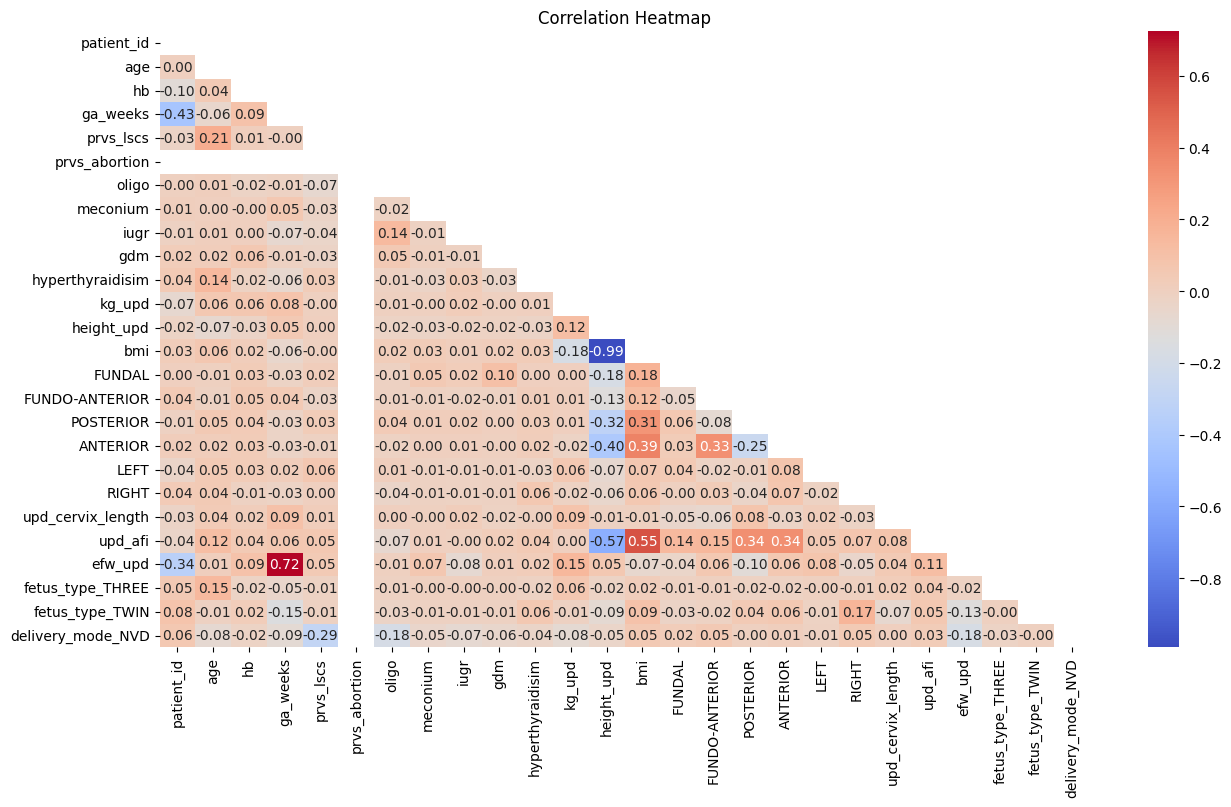

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix  = df_upd_merge_imputed_ohe.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask =  mask)
plt.title('Correlation Heatmap')
plt.show()

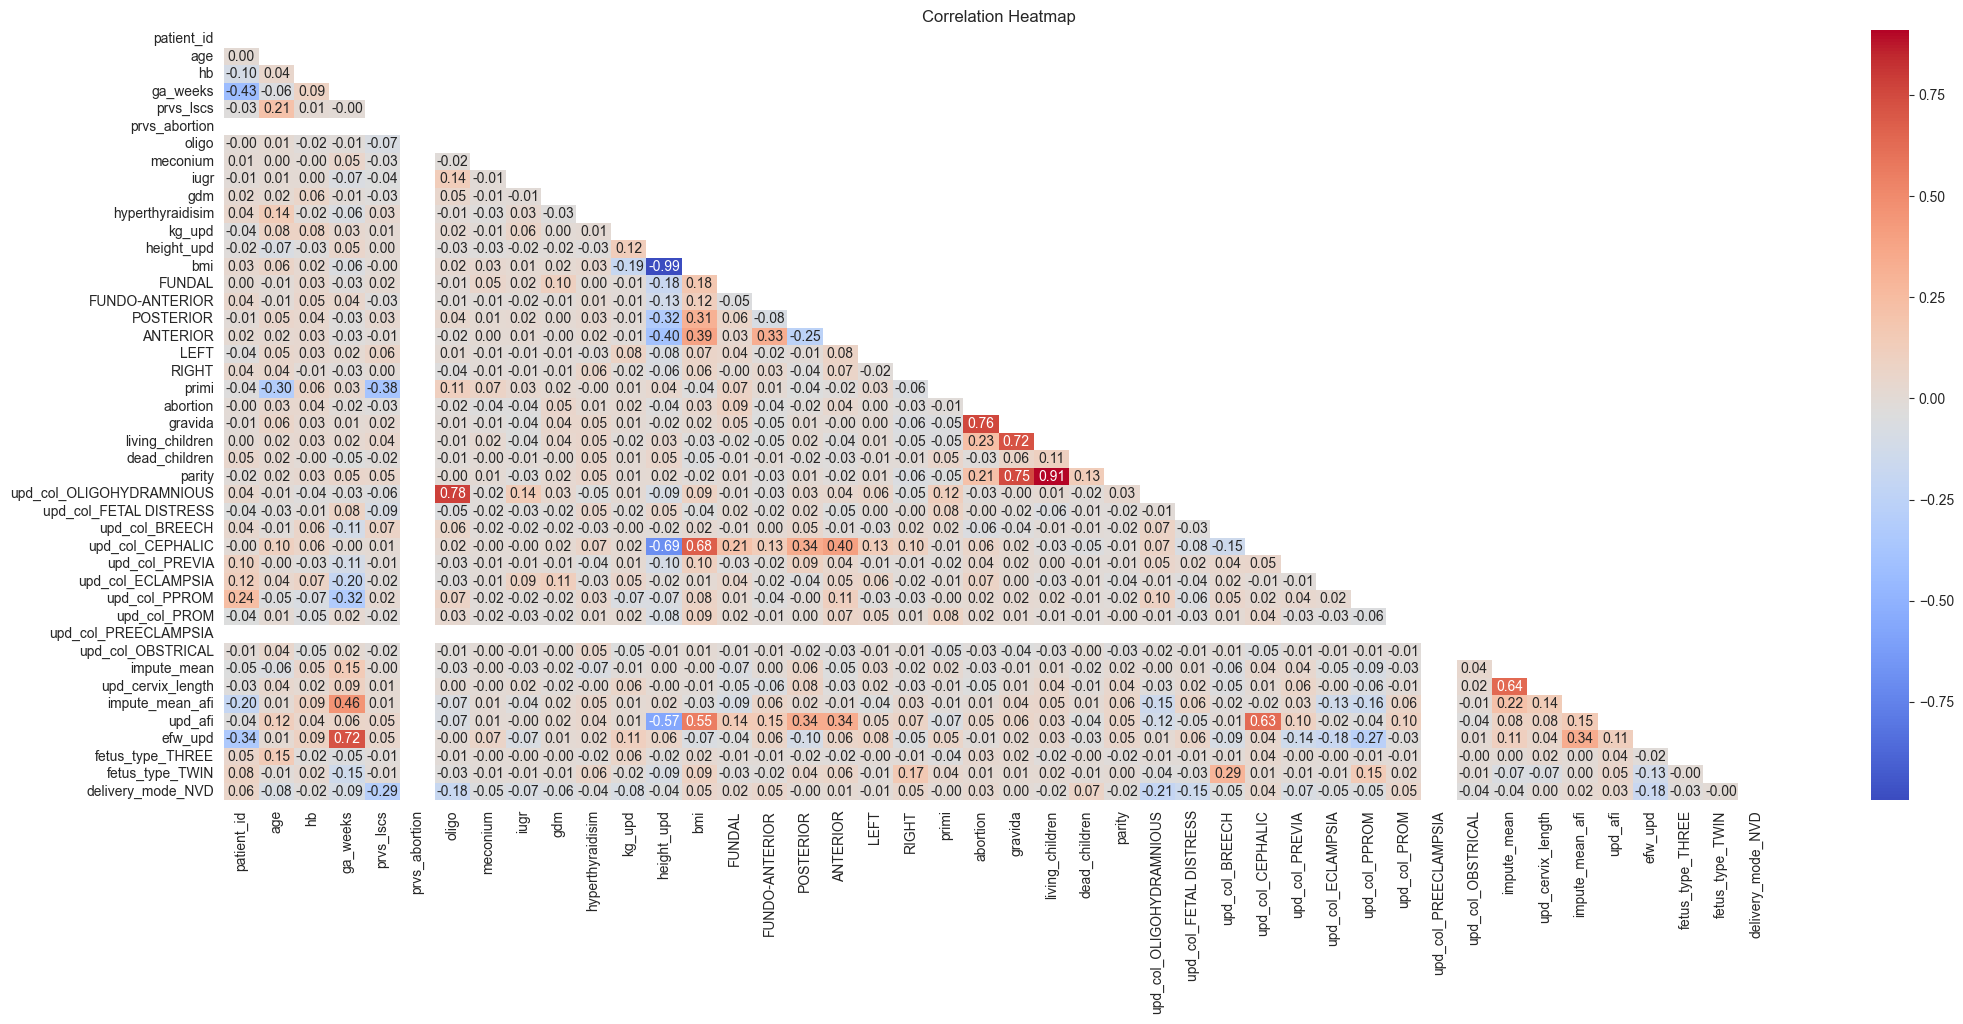

In [412]:

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_upd_merge_imputed_ohe.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap')
plt.show()

In [414]:
df_upd_merge_imputed_ohe.drop(columns=['oligo','prvs_abortion','fhr_upd'],inplace=True)

In [424]:
# df_upd_merge_imputed_ohe.drop(columns=['bp'],inplace=True)
df_upd_merge_imputed_ohe.drop(columns=['impute_mean','impute_mean_afi'],inplace=True)


In [425]:
df_upd_merge_imputed_ohe

,patient_id,age,hb,ga_weeks,prvs_lscs,meconium,iugr,gdm,hyperthyraidisim,kg_upd,height_upd,bmi,FUNDAL,FUNDO-ANTERIOR,POSTERIOR,ANTERIOR,LEFT,RIGHT,primi,abortion,gravida,living_children,dead_children,parity,upd_col_OLIGOHYDRAMNIOUS,upd_col_FETAL DISTRESS,upd_col_BREECH,upd_col_CEPHALIC,upd_col_PREVIA,upd_col_ECLAMPSIA,upd_col_PPROM,upd_col_PROM,upd_col_PREECLAMPSIA,upd_col_OBSTRICAL,upd_cervix_length,upd_afi,efw_upd,fetus_type_THREE,fetus_type_TWIN,delivery_mode_NVD
0,0,39.0,10.6,37.0,1.0,0.0,0.0,0.0,0.0,77.000000,0.770000,129.870130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,3.45,15.4,3044.000000,0,0,0
1,1,32.0,9.3,37.0,1.0,0.0,0.0,0.0,1.0,79.000000,0.790000,126.582278,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1.0,0.0,1.0,0,1,0,1,0,0,0,0,0,0,3.60,10.1,2176.000000,0,0,0
2,2,31.0,10.3,37.0,0.0,0.0,0.0,0.0,0.0,62.000000,0.620000,161.290323,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,3.45,6.4,3110.000000,0,0,0
3,3,28.0,12.2,37.0,0.0,0.0,0.0,0.0,1.0,40.000000,0.400000,250.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,3.40,9.3,1370.000000,0,0,1
4,4,31.0,11.1,37.0,0.0,0.0,0.0,0.0,0.0,71.000000,0.710000,140.845070,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,4.30,10.9,2862.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,741,22.0,10.8,25.0,0.0,0.0,0.0,0.0,0.0,68.000000,0.680000,147.058824,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.0,1.0,0,0,0,1,1,0,0,0,0,0,4.80,14.0,333.000000,0,0,0
742,742,29.0,10.8,25.0,0.0,0.0,0.0,0.0,0.0,60.000000,0.600000,166.666667,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,4.10,5.5,505.482869,0,0,1
743,743,32.0,11.1,25.0,0.0,0.0,0.0,0.0,0.0,74.802475,1.491121,33.642652,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,4.10,4.1,641.660837,0,0,1
744,744,32.0,11.5,23.0,0.0,0.0,0.0,0.0,1.0,55.000000,0.550000,181.818182,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3,1.0,0.0,1.0,0,0,1,0,0,0,0,1,0,0,1.60,11.1,714.000000,0,1,1


In [426]:
from sklearn.model_selection import train_test_split

X = df_upd_merge_imputed_ohe.drop(columns=['patient_id','delivery_mode_NVD'])
y = df_upd_merge_imputed_ohe['delivery_mode_NVD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.value_counts(), y_test.value_counts())

(596, 38) (150, 38)
0    391
1    205
Name: delivery_mode_NVD, dtype: int64 0    101
1     49
Name: delivery_mode_NVD, dtype: int64


In [427]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 11, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3, verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['log2', 'sqrt'], 'max_depth': [5, 6, 7, 8, 9, 11, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 9, 11, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

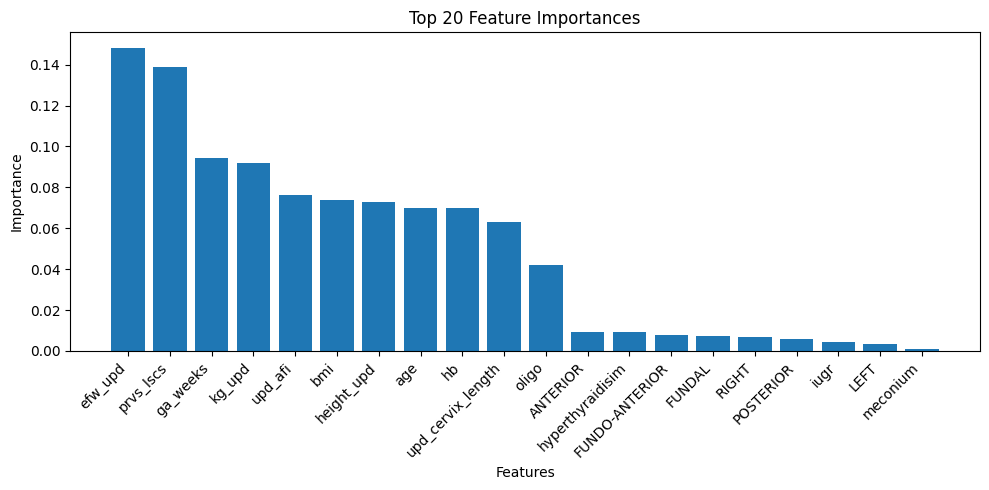

In [276]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_random, feature_names, and X_train are already defined
best_random = rf_random.best_estimator_
feature_names = X_train.columns.tolist()
# Get feature importances
importances = best_random.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Get the feature names, sorted by importance
names = [feature_names[i] for i in indices]

# Number of features to display
num_features = 20

# Limit the data to the top 'num_features' features
sorted_importances = importances[indices[:num_features]]
sorted_names = [names[i] for i in range(num_features)]

# Create the plot
plt.figure(figsize=(10, 5))
plt.title("Top 20 Feature Importances")
plt.bar(range(num_features), sorted_importances)
plt.xticks(range(num_features), sorted_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

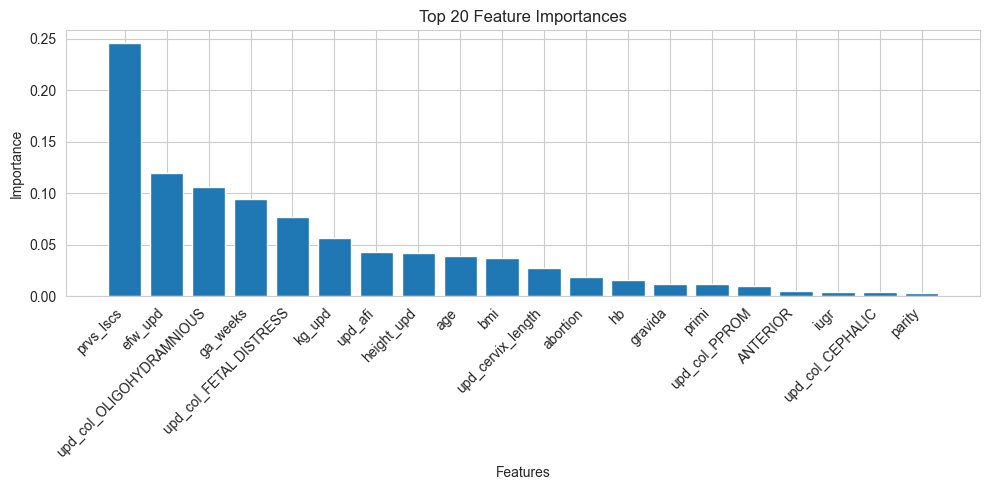

In [428]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_random, feature_names, and X_train are already defined
best_random = rf_random.best_estimator_
feature_names = X_train.columns.tolist()
# Get feature importances
importances = best_random.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Get the feature names, sorted by importance
names = [feature_names[i] for i in indices]

# Number of features to display
num_features = 20

# Limit the data to the top 'num_features' features
sorted_importances = importances[indices[:num_features]]
sorted_names = [names[i] for i in range(num_features)]

# Create the plot
plt.figure(figsize=(10, 5))
plt.title("Top 20 Feature Importances")
plt.bar(range(num_features), sorted_importances)
plt.xticks(range(num_features), sorted_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

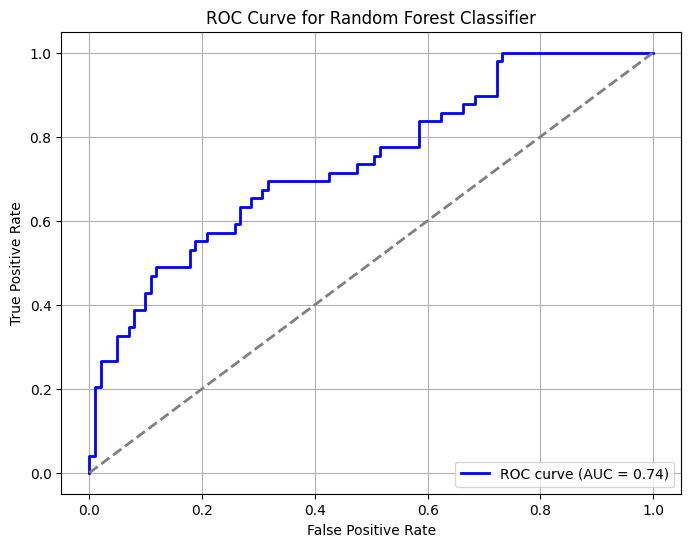

In [277]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = best_random.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

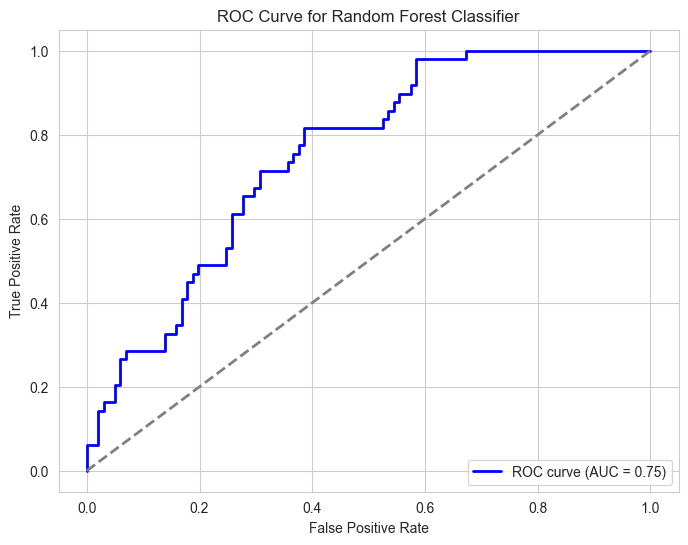

In [429]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = best_random.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# DEEP LEARNING
# AUTO GLUON

# FNN -
# ENCODER BASED